In [34]:
# imports
import os
from types import SimpleNamespace
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.colors as mcolors
import numpy as np

In [90]:
t2p_save_path = "/Users/manonmantez/Desktop/jm038/t2p_affine_chan1_all_"  # (change this based on your data)
plane = 'plane0' # which plane to process (the example dataset is single-plane)

In [91]:
# np.load() the match matrix (plane0_match_mat.npy)
t2p_match_mat = np.load(os.path.join(t2p_save_path,'track2p', f'{plane}_match_mat.npy'), allow_pickle=True)

# np.load() settings (this contains suite2p paths etc.) (track_ops.npy)
track_ops_dict = np.load(os.path.join(t2p_save_path, 'track2p', 'track_ops.npy'), allow_pickle=True).item()
track_ops = SimpleNamespace(**track_ops_dict) # create dummy object from the track_ops dictionary

print(t2p_save_path)
print(track_ops.save_path)
print(track_ops.reg_chan)
print(track_ops.transform_type)
print(t2p_match_mat.shape)
#print(t2p_match_mat)

/Users/manonmantez/Desktop/jm038/t2p_affine_chan1_all_
/Users/manonmantez/Desktop/jm038/track2p/
1
affine
(2190, 7)


[[ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True False False False False]
 [ True  True  True  True  True  True  True]
 [ True  True  True False False False False]
 [ True  True  True  True  True  True  True]
 [False False False False False False False]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True False False False False]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True False False False False]
 [ True  T

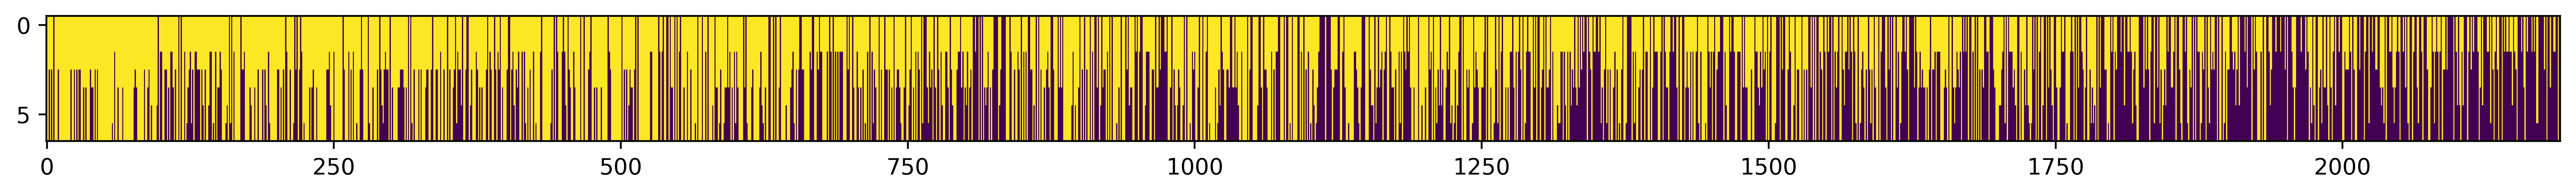

In [92]:
t2p_match_mat_notnone = t2p_match_mat != None #bolean matrix
print(t2p_match_mat_notnone)
plt.figure(figsize=(20, 1), dpi=500)
plt.imshow(t2p_match_mat_notnone.T, aspect='auto', vmin=0, vmax=1)


In [93]:
print('Datasets used for t2p:\n')
for ds_path in track_ops.all_ds_path:
    iscell=np.load(os.path.join(ds_path,'suite2p', 'plane0','iscell.npy'))
    iscell = iscell[iscell[:, 0] > track_ops.iscell_thr]
    print(len(iscell))


Datasets used for t2p:

2190
2247
2098
2002
1794
1730
1622


## Above is the output of the algorithm, now generate ground truth

### Generate grid

In [94]:
# load the suite2p output of the first dataset
s2p_path = os.path.join(track_ops.all_ds_path[0], 'suite2p', plane)
print(track_ops.all_ds_path)

# load the ops and stat
ops_first = np.load(os.path.join(s2p_path, 'ops.npy'), allow_pickle=True).item()
stat_first = np.load(os.path.join(s2p_path, 'stat.npy'), allow_pickle=True)
iscell_first = np.load(os.path.join(s2p_path, 'iscell.npy'), allow_pickle=True)
s2p_inds = np.arange(len(stat_first))

# filter stat based on the track2p probability
print(f'Filtering stat based on the track2p probability (iscell_thr={track_ops.iscell_thr})')
s2p_inds_iscell = s2p_inds[iscell_first[:, 0] > track_ops.iscell_thr]
stat_first_iscell = stat_first[iscell_first[:, 0] > track_ops.iscell_thr]
print(f'Filtered stat from {len(stat_first)} to {len(stat_first_iscell)} cells')



['/Users/manonmantez/Desktop/jm038/2023-04-30_a', '/Users/manonmantez/Desktop/jm038/2023-05-01_a', '/Users/manonmantez/Desktop/jm038/2023-05-02_a', '/Users/manonmantez/Desktop/jm038/2023-05-03_a', '/Users/manonmantez/Desktop/jm038/2023-05-04_a', '/Users/manonmantez/Desktop/jm038/2023-05-05_a', '/Users/manonmantez/Desktop/jm038/2023-05-06_a']
Filtering stat based on the track2p probability (iscell_thr=0.5)
Filtered stat from 3587 to 2190 cells


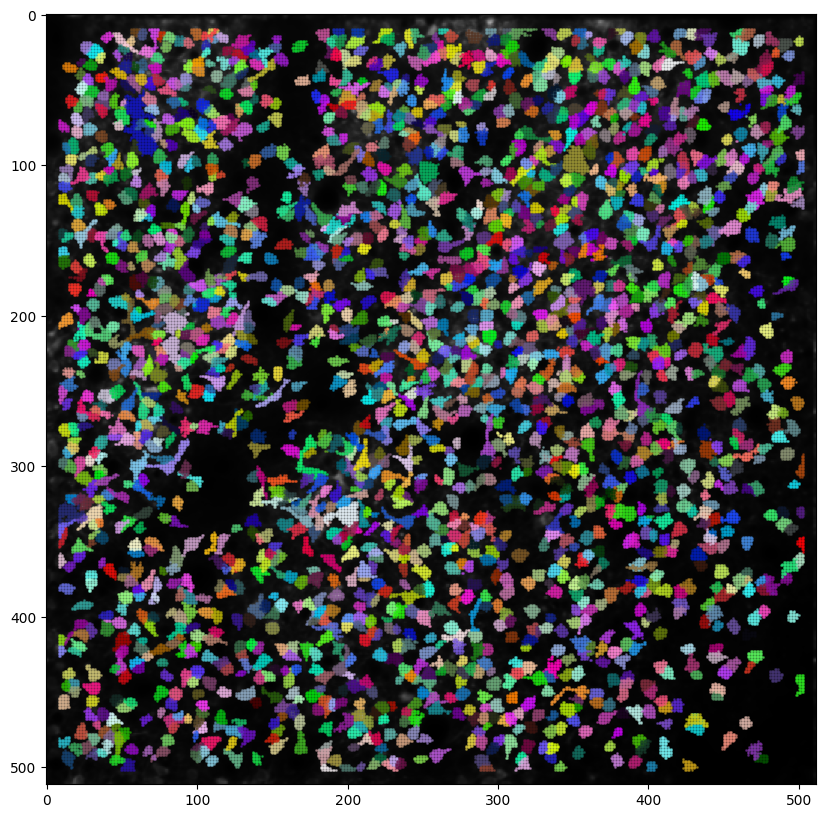

In [95]:
# now plot the fov with contours
plt.figure(figsize=(10, 10))
plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(len(stat_first_iscell)):
    # get random color 
    color = np.random.rand(3)
    plt.scatter(stat_first_iscell[i]['xpix'], stat_first_iscell[i]['ypix'], s=1, color=color, alpha=0.5)

(-0.5, 511.5, 511.5, -0.5)

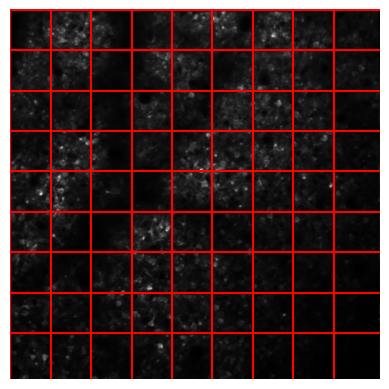

In [96]:
# now make a 8x8 grid on the image
n_grid = 9
grid_x = np.arange(0, ops_first['meanImg'].shape[1], ops_first['meanImg'].shape[1] // n_grid)
grid_y = np.arange(0, ops_first['meanImg'].shape[0], ops_first['meanImg'].shape[0] // n_grid)

plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(n_grid):
    plt.axvline(grid_x[i], color='r')
    plt.axhline(grid_y[i], color='r')

plt.axis('off')

In [97]:
# now for each grid cross get the nearest cell (except for 0 and 512 pixels)
all_cell_med = []

# get all cell medians from stat
for i in range(len(stat_first_iscell)):
    all_cell_med.append(stat_first_iscell[i]['med'])
    

In [98]:
# compute coordinates of the grid crosses
grid_crosses = []
for i in range(1, n_grid):
    for j in range(1, n_grid):
        grid_crosses.append((grid_x[i], grid_y[j]))

In [99]:
grid_crosses

[(56, 56),
 (56, 112),
 (56, 168),
 (56, 224),
 (56, 280),
 (56, 336),
 (56, 392),
 (56, 448),
 (112, 56),
 (112, 112),
 (112, 168),
 (112, 224),
 (112, 280),
 (112, 336),
 (112, 392),
 (112, 448),
 (168, 56),
 (168, 112),
 (168, 168),
 (168, 224),
 (168, 280),
 (168, 336),
 (168, 392),
 (168, 448),
 (224, 56),
 (224, 112),
 (224, 168),
 (224, 224),
 (224, 280),
 (224, 336),
 (224, 392),
 (224, 448),
 (280, 56),
 (280, 112),
 (280, 168),
 (280, 224),
 (280, 280),
 (280, 336),
 (280, 392),
 (280, 448),
 (336, 56),
 (336, 112),
 (336, 168),
 (336, 224),
 (336, 280),
 (336, 336),
 (336, 392),
 (336, 448),
 (392, 56),
 (392, 112),
 (392, 168),
 (392, 224),
 (392, 280),
 (392, 336),
 (392, 392),
 (392, 448),
 (448, 56),
 (448, 112),
 (448, 168),
 (448, 224),
 (448, 280),
 (448, 336),
 (448, 392),
 (448, 448)]

(-0.5, 511.5, 511.5, -0.5)

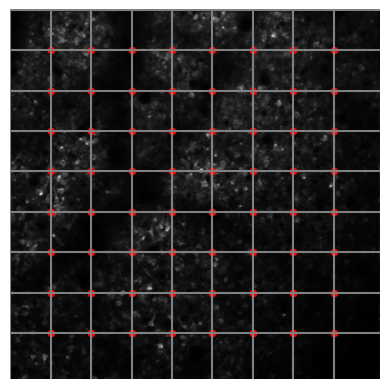

In [100]:
plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(n_grid):
    plt.axvline(grid_x[i], color='gray')
    plt.axhline(grid_y[i], color='gray')
for cross in grid_crosses:
    plt.scatter(cross[0], cross[1], s=20, color='r')

plt.axis('off')


In [101]:
# compute distances between each cell and each grid cross
distances = np.zeros((len(stat_first_iscell), len(grid_crosses)))
for i, cell_med in enumerate(all_cell_med):
    for j, cross in enumerate(grid_crosses):
        distances[i, j] = np.sqrt((cell_med[0] - cross[0])**2 + (cell_med[1] - cross[1])**2)

In [102]:
# now get the nearest cell for each grid cross
nearest_cells = np.argmin(distances, axis=0)

In [103]:
nearest_cells

array([1494, 1140, 1449,  265, 1146,  924,  177, 2168, 1172,  913, 1927,
       1002, 1454,  237,  505, 1722, 1304, 1943, 1190, 1987,  429, 1490,
       2153,  364,  139, 1320, 1975,  533,  445, 1506, 1213,  880,  111,
       1217, 1520,  279, 1831, 1698,  582, 1829,  811, 1678,   79, 1293,
       1672, 1382, 1988,  980,   66, 1083,  814,   68, 1992,  856, 1679,
       1424, 1612,  984, 1258,  368,  610,  721, 1085, 2055])

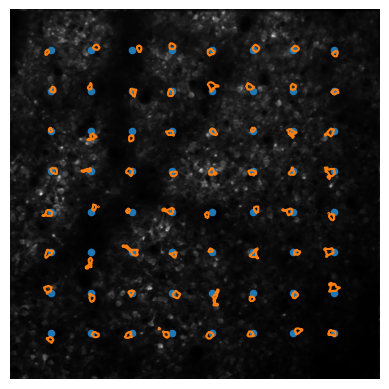

In [104]:
plt.imshow(ops_first['meanImg'], cmap='gray')

for cross in grid_crosses:
    plt.scatter(cross[0], cross[1], s=20, color='C0')

plt.axis('off')

for i, cell in enumerate(nearest_cells):
    roi = np.zeros_like(ops_first['meanImg'])
    roi[stat_first_iscell[cell]['ypix'], stat_first_iscell[cell]['xpix']] = 1
    plt.contour(roi, levels=[0.5], colors='C1')

In [105]:
# now get the original indices
original_indices = s2p_inds_iscell[nearest_cells]
print('Now open suite2p and try to manually track cells:')
[print(f'{original_indices[i]}') for i in range(len(original_indices))]

Now open suite2p and try to manually track cells:
1779
1254
1708
267
1263
985
179
3480
1301
973
2719
1083
1717
239
511
2212
1480
2751
1326
2874
432
1773
3425
366
141
1506
2840
540
448
1796
1356
935
113
1362
1817
281
2450
2166
592
2447
853
2124
81
1464
2115
1601
2875
1059
67
1181
856
70
2881
905
2126
1672
1990
1065
1419
370
622
746
1183
3060


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

(-0.5, 511.5, 511.5, -0.5)

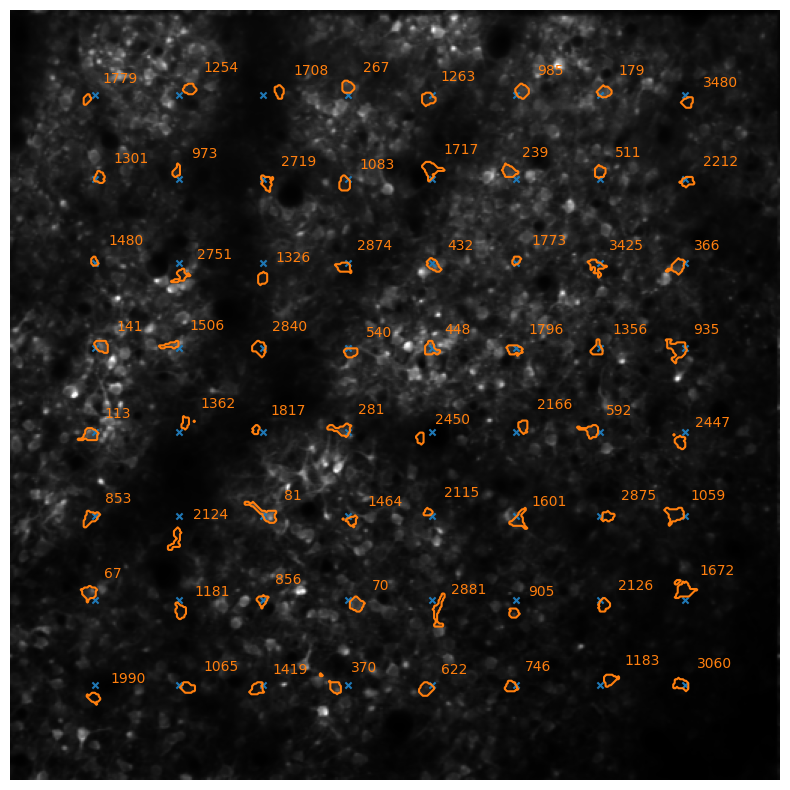

In [106]:
# make the same plot as above but with numbers labeled next to the roi
plt.figure(figsize=(10, 10))
# clip based on 99.99 percentile
img = ops_first['meanImg'].copy()
img[img > np.percentile(img, 99.99)] = np.percentile(img, 99.99)
plt.imshow(img, cmap='gray')

for i, cell in enumerate(nearest_cells):
    roi = np.zeros_like(ops_first['meanImg'])
    roi[stat_first_iscell[cell]['ypix'], stat_first_iscell[cell]['xpix']] = 1
    plt.contour(roi, levels=[0.5], colors='C1')
    plt.text(stat_first_iscell[cell]['med'][1]+10, stat_first_iscell[cell]['med'][0]-10, f'{original_indices[i]}', color='C1')
    plt.scatter(grid_crosses[i][0], grid_crosses[i][1], s=20, color='C0', marker='x')

plt.axis('off')

In [107]:
np.sort(original_indices)

array([  67,   70,   81,  113,  141,  179,  239,  267,  281,  366,  370,
        432,  448,  511,  540,  592,  622,  746,  853,  856,  905,  935,
        973,  985, 1059, 1065, 1083, 1181, 1183, 1254, 1263, 1301, 1326,
       1356, 1362, 1419, 1464, 1480, 1506, 1601, 1672, 1708, 1717, 1773,
       1779, 1796, 1817, 1990, 2115, 2124, 2126, 2166, 2212, 2447, 2450,
       2719, 2751, 2840, 2874, 2875, 2881, 3060, 3425, 3480])

### Getting real suite2p indexes to compare it to

In [23]:
def function(path, plane):

    track_ops_dict = np.load(os.path.join(path, "track2p", "track_ops.npy"), allow_pickle=True).item()
    track_ops = SimpleNamespace(**track_ops_dict)
    t2p_match_mat = np.load(os.path.join(path,"track2p" ,f"{plane}_match_mat.npy"), allow_pickle=True)
    #t2p_match_mat_allday = t2p_match_mat
    
    if track_ops.iscell_thr is not None:
        true_indices= np.empty((len(t2p_match_mat), len(track_ops.all_ds_path)), dtype=object)
        
    for j in range(len(t2p_match_mat)):
        for (i, ds_path) in enumerate(track_ops.all_ds_path):
            iscell = np.load(os.path.join(ds_path, 'suite2p', plane, 'iscell.npy'), allow_pickle=True)
            if track_ops.iscell_thr is not None:
                s2p_indexes= np.where(iscell[:,1]>track_ops.iscell_thr)[0]
                t2p_index=t2p_match_mat[j,i]

                if t2p_index is None:
                    true_index = None
                else:
                    true_index=s2p_indexes[t2p_index]

                true_indices[j, i] = true_index
            else:
                pass
    if track_ops.iscell_thr is not None:        
        np.save(os.path.join(path, "true_indices.npy"), true_indices)
        print("saved")
    else:
        print("not in locals")
        

In [108]:
#only if nerver done for this condition and this mouse before !!!! 
function(t2p_save_path, plane)  

saved


In [109]:
indices_npy= np.load(os.path.join(t2p_save_path,"true_indices.npy"), allow_pickle=True)
print(indices_npy)
print(indices_npy.shape)
print(t2p_save_path)

#indices_npy (index of the cell in the suite2p output)

[[0 2 36 22 456 21 202]
 [1 60 13 3 14 47 55]
 [2 16 88 None None None None]
 [3 4 2 1 4 0 34]
 [4 33 190 None None None None]
 [5 80 42 233 778 768 547]
 [None None None None None None None]
 [7 9 40 32 109 285 230]
 [8 1 8 9 5 4 132]
 [9 12 4 21 310 33 28]
 [10 63 39 None None None None]
 [11 103 26 194 44 151 62]
 [12 35 10 10 116 17 5]
 [13 0 1 4 3 2 0]
 [14 5 46 92 274 286 475]
 [15 121 67 55 231 43 38]
 [16 10 22 2 79 9 6]
 [17 132 203 78 28 78 189]
 [18 7 52 71 153 137 383]
 [19 27 149 53 18 19 37]
 [20 19 14 12 32 56 35]
 [21 62 92 None None None None]
 [22 126 9 13 8 24 46]
 [23 25 50 261 386 29 259]
 [24 328 49 None None None None]
 [25 64 5 11 2 11 100]
 [26 47 1218 None None None None]
 [27 137 91 452 358 339 164]
 [28 3 18 None None None None]
 [29 29 2616 None None None None]
 [30 70 95 94 121 92 158]
 [31 94 187 135 63 74 235]
 [32 36 234 319 None None None]
 [33 18 45 193 475 330 409]
 [34 101 206 492 None None None]
 [35 50 28 87 335 204 32]
 [36 43 74 716 360 235 77]


In [110]:
# Configurer numpy pour afficher tout le tableau sans troncature
np.set_printoptions(threshold=np.inf)
print(indices_npy)

[[0 2 36 22 456 21 202]
 [1 60 13 3 14 47 55]
 [2 16 88 None None None None]
 [3 4 2 1 4 0 34]
 [4 33 190 None None None None]
 [5 80 42 233 778 768 547]
 [None None None None None None None]
 [7 9 40 32 109 285 230]
 [8 1 8 9 5 4 132]
 [9 12 4 21 310 33 28]
 [10 63 39 None None None None]
 [11 103 26 194 44 151 62]
 [12 35 10 10 116 17 5]
 [13 0 1 4 3 2 0]
 [14 5 46 92 274 286 475]
 [15 121 67 55 231 43 38]
 [16 10 22 2 79 9 6]
 [17 132 203 78 28 78 189]
 [18 7 52 71 153 137 383]
 [19 27 149 53 18 19 37]
 [20 19 14 12 32 56 35]
 [21 62 92 None None None None]
 [22 126 9 13 8 24 46]
 [23 25 50 261 386 29 259]
 [24 328 49 None None None None]
 [25 64 5 11 2 11 100]
 [26 47 1218 None None None None]
 [27 137 91 452 358 339 164]
 [28 3 18 None None None None]
 [29 29 2616 None None None None]
 [30 70 95 94 121 92 158]
 [31 94 187 135 63 74 235]
 [32 36 234 319 None None None]
 [33 18 45 193 475 330 409]
 [34 101 206 492 None None None]
 [35 50 28 87 335 204 32]
 [36 43 74 716 360 235 77]


In [111]:
# index rows for cells where the first row is in original_indices
all_s2p_idxs = []
for idx in np.sort(original_indices):
    idx_row = np.where(indices_npy[:,0]==idx)

    if len(idx_row[0]) == 0:
        s2p_idxs = [None]*len(track_ops.all_ds_path)
        #print('here')

    else:
        s2p_idxs = indices_npy[idx_row]
    all_s2p_idxs.append(s2p_idxs[0])

all_s2p_idxs = np.array(all_s2p_idxs)

#print(all_s2p_idxs.dtype)
print(f'all_s2p_idxs {all_s2p_idxs}')

all_s2p_idxs [array([67, 38, 15, 169, None, None, None], dtype=object)
 array([70, 193, 224, 119, 120, 199, 76], dtype=object)
 array([81, 187, 65, 50, 21, 129, 11], dtype=object)
 array([113, 67, 170, 46, 487, 32, 99], dtype=object)
 array([141, 140, 553, 713, 1116, 10, 12], dtype=object)
 array([179, 521, 823, 230, None, None, None], dtype=object)
 array([239, 154, 417, 16, 52, 94, 30], dtype=object)
 array([267, 313, 38, None, None, None, None], dtype=object)
 array([281, 953, 294, 208, 26, 80, 84], dtype=object)
 array([366, 118, 150, 36, 19, 26, 218], dtype=object)
 array([370, 786, 1271, 842, 421, 472, 488], dtype=object)
 array([432, 538, 370, 612, 188, 722, 510], dtype=object)
 array([448, 3060, None, None, None, None, None], dtype=object)
 array([511, 874, 880, None, None, None, None], dtype=object) None None
 array([622, 434, 1141, 888, 1133, 1789, None], dtype=object)
 array([746, 1285, 1446, None, None, None, None], dtype=object) None
 array([856, 1163, 1085, 1056, 441, 465

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Loading and processing cellreg outputs

In [254]:
# check if you are using track2p with channel 1 for each mouse (if not, change the path)
from scipy.io import savemat
import sys

for i, ds_path in enumerate(track_ops.all_ds_path):

    iscell = np.load(os.path.join(ds_path, 'suite2p', f'plane{plane}', 'iscell.npy'), allow_pickle=True)
    stat = np.load(os.path.join(ds_path, 'suite2p', f'plane{plane}', 'stat.npy'), allow_pickle=True)
    ops = np.load(os.path.join(ds_path, 'suite2p', f'plane{plane}', 'ops.npy'), allow_pickle=True).item()
    

    ind_iscell = np.where(iscell[:, 1] > 0.5)[0]  # Extraire les indices dans un tableau
    print(f"Indices des cellules : {ind_iscell}")


    Ly, Lx = int(ops['Ly']), int(ops['Lx'])
    N = len(ind_iscell)  
    print(f"Nombre de cellules : {N}")

    footprints = np.zeros((N, Ly, Lx), dtype=np.int16)

    for neuron_idx, cell_idx in enumerate(ind_iscell):
        cell_stat = stat[cell_idx]

        ypix = cell_stat['ypix']
        xpix = cell_stat['xpix']
        lam = cell_stat['lam']

        footprints[neuron_idx, ypix, xpix] = lam.astype(np.int16)


    save_path_part = os.path.join(ds_path, 'footprints_part.mat')

    print(sys.getsizeof(footprints))
    
    
    savemat(save_path_part, {'footprints_part1': footprints})


FileNotFoundError: [Errno 2] No such file or directory: '/Users/manonmantez/Desktop/jm038/2023-04-30_a/suite2p/planeplane0/iscell.npy'

In [299]:
new_path = os.path.dirname(t2p_save_path)
cellreg_path = os.path.join(new_path, 'cellreg')
print(cellreg_path)

/Volumes/data_jm_share/data_proc/jm/jm038/cellreg


In [286]:
import h5py

# this is the directory that contains a /track2p folder that is output by running the track2p algorithm
# load the data

with h5py.File(os.path.join(cellreg_path, "cellRegistered.mat"), 'r') as f:
    # Accéder au dataset spécifique
    cell_to_index_map = f['cell_registered_struct/cell_to_index_map']
 
    cell_to_index_map = np.array(cell_to_index_map)
    print(cell_to_index_map.shape)

    # Filtrer les colonnes où la première ligne n'est pas égale à 0
    # Pour avoir la même shape que le tableau de match de track2p (autant de lignes que dans iscell > 0.5 du jour 1)
    mask0 = cell_to_index_map[0, :] != 0
    filtered_cell_to_index_map = cell_to_index_map[:, mask0]
    print(filtered_cell_to_index_map.astype(int))

    # Convertir en entier
    filtered_cell_to_index_map = filtered_cell_to_index_map.astype(int)

    # Remplacer les zéros par None et décrémenter les autres chiffres de 1
    filtered_cell_to_index_map = np.where(filtered_cell_to_index_map == 0, None, filtered_cell_to_index_map - 1)
    print(filtered_cell_to_index_map)

    # Enregistrer le tableau modifié
    np.save(os.path.join(cellreg_path, "plane0_match_mat_cellreg.npy"), filtered_cell_to_index_map)
    print("NumPy file 'plane0_match_mat_cellreg.npy' created successfully.")


(7, 11766)
[[   2    3    4    6    7   11   12   13   14   15   17   19   21   22
    23   24   25   26   27   28   30   31   32   33   35   36   37   38
    39   40   41   42   44   45   47   49   50   51   52   53   54   55
    56   57   58   59   60   61   63   64   65   66   68   69   70   75
    76   77   78   79   80   81   82   83   85   86   87   88   89   91
    93   94   96   98   99  100  101  102  104  105  106  107  108  109
   111  112  113  114  115  116  117  118  119  120  121  122  125  126
   127  128  130  131  133  135  136  137  138  139  140  141  142  143
   145  146  148  149  150  151  153  154  155  156  158  161  162  163
   164  166  167  168  169  170  171  172  173  175  176  177  178  179
   181  182  183  184  186  187  188  189  190  191  192  193  194  195
   196  197  198  199  201  203  207  208  209  210  212  213  214  216
   217  218  220  221  222  224  226  228  229  231  234  235  236  238
   240  241  244  245  248  250  251  252  253  254  

In [300]:
cellreg_match_mat = np.load(os.path.join(cellreg_path, "plane0_match_mat_cellreg.npy"), allow_pickle=True)
print(cellreg_match_mat)
print(cellreg_match_mat.shape)

[[1 2 3 5 6 10 11 12 13 14 16 18 20 21 22 23 24 25 26 27 29 30 31 32 34
  35 36 37 38 39 40 41 43 44 46 48 49 50 51 52 53 54 55 56 57 58 59 60 62
  63 64 65 67 68 69 74 75 76 77 78 79 80 81 82 84 85 86 87 88 90 92 93 95
  97 98 99 100 101 103 104 105 106 107 108 110 111 112 113 114 115 116
  117 118 119 120 121 124 125 126 127 129 130 132 134 135 136 137 138 139
  140 141 142 144 145 147 148 149 150 152 153 154 155 157 160 161 162 163
  165 166 167 168 169 170 171 172 174 175 176 177 178 180 181 182 183 185
  186 187 188 189 190 191 192 193 194 195 196 197 198 200 202 206 207 208
  209 211 212 213 215 216 217 219 220 221 223 225 227 228 230 233 234 235
  237 239 240 243 244 247 249 250 251 252 253 255 257 258 260 261 262 263
  264 266 267 268 270 272 273 275 276 277 278 279 281 284 285 286 287 288
  290 291 293 294 295 296 297 298 299 300 301 302 303 304 306 307 308 311
  312 313 314 315 316 318 319 320 321 322 323 324 326 327 328 329 330 331
  332 333 334 335 336 338 339 341 342 343 3

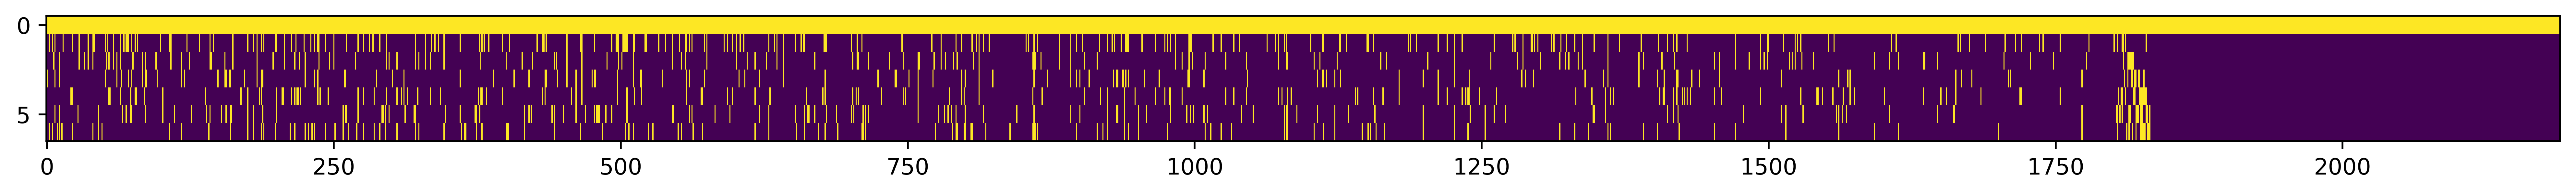

In [301]:
# Afficher le tableau modifié avec plt.imshow
bool_array = np.where(cellreg_match_mat == None, 0, 1).astype(bool)
plt.figure(figsize=(20, 1), dpi=500)
plt.imshow(bool_array,  aspect='auto', vmin=0, vmax=1)
plt.show()

In [302]:
cellreg_match_mat = cellreg_match_mat.T

In [303]:
cellreg_match_mat

array([[1, None, None, 1143, None, None, None],
       [2, None, None, None, None, None, None],
       [3, 308, None, None, None, None, 784],
       [5, None, None, None, None, None, None],
       [6, None, None, None, None, None, None],
       [10, 63, None, None, None, None, 67],
       [11, None, 230, None, None, None, None],
       [12, 905, None, 1099, None, 531, None],
       [13, None, None, None, None, None, None],
       [14, None, None, None, None, None, 876],
       [16, None, None, None, None, None, None],
       [18, None, 591, 763, None, 660, 523],
       [20, None, None, None, None, None, None],
       [21, None, None, None, None, None, 51],
       [22, 909, None, None, None, None, None],
       [23, None, None, None, None, None, None],
       [24, None, None, None, None, None, None],
       [25, None, None, None, None, None, None],
       [26, None, None, None, None, None, None],
       [27, None, None, None, None, None, None],
       [29, None, None, None, None, None, 

In [304]:
for i in range(len(cellreg_match_mat)):
    if all(x is None for x in cellreg_match_mat[i][1:]):
        cellreg_match_mat[i] = None

In [305]:
cellreg_match_mat

array([[1, None, None, 1143, None, None, None],
       [None, None, None, None, None, None, None],
       [3, 308, None, None, None, None, 784],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [10, 63, None, None, None, None, 67],
       [11, None, 230, None, None, None, None],
       [12, 905, None, 1099, None, 531, None],
       [None, None, None, None, None, None, None],
       [14, None, None, None, None, None, 876],
       [None, None, None, None, None, None, None],
       [18, None, 591, 763, None, 660, 523],
       [None, None, None, None, None, None, None],
       [21, None, None, None, None, None, 51],
       [22, 909, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, Non

In [306]:
# For same as t2p_match_mat
for i in range(len(cellreg_match_mat)):
    if cellreg_match_mat[i,1] is None:
        cellreg_match_mat[i] = None

#ne pas faire si cellreg pairs


In [307]:
cellreg_match_mat

array([[None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [3, 308, None, None, None, None, 784],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [10, 63, None, None, None, None, 67],
       [None, None, None, None, None, None, None],
       [12, 905, None, 1099, None, 531, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [22, 909, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None]

#### Getting real suite2p indexes to compare it to

In [27]:
def function_cellreg(path, plane):

    if track_ops.iscell_thr is not None:
        true_indices= np.empty(cellreg_match_mat.shape, dtype=object)
        print(true_indices.shape)
        
    for (i, ds_path) in enumerate(track_ops.all_ds_path):
        iscell = np.load(os.path.join(ds_path, 'suite2p', plane, 'iscell.npy'), allow_pickle=True)
        s2p_indexes= np.where(iscell[:,1]>track_ops.iscell_thr)[0]
        #print(s2p_indexes)
        print(f'suite2P {len(s2p_indexes)}')
        for j in range(cellreg_match_mat.shape[0]):
                if track_ops.iscell_thr is not None:
                    cellreg_index=cellreg_match_mat[j,i]
                    print(cellreg_index)

                if cellreg_index is None :
                    true_index = None
                else:
                    true_index=s2p_indexes[cellreg_index]

                true_indices[j, i] = true_index
        else:
            pass
    if track_ops.iscell_thr is not None:        
        np.save(os.path.join(path, "true_indices_cellreg.npy"), true_indices)
        print("saved")
    else:
        print("not in locals")
        

In [28]:
function_cellreg(cellreg_path, plane)  

NameError: name 'cellreg_path' is not defined

In [ ]:
indices_cellreg_npy= np.load(os.path.join(cellreg_path,"true_indices_cellreg.npy"), allow_pickle=True)
print(indices_cellreg_npy)
print(indices_cellreg_npy.shape)

[[None None None None None None None]
 [None None None None None None None]
 [3 310 None None None None 803]
 [None None None None None None None]
 [None None None None None None None]
 [10 63 None None None None 68]
 [None None None None None None None]
 [12 928 None 1140 None 531 None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [22 932 None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [31 94 None None 1381 None 2571]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None No

In [311]:
# index rows for cells where the first row is in original_indices
all_s2p_idxs_cellreg = []
for idx in np.sort(original_indices):
    idx_row = np.where(indices_cellreg_npy[:,0]==idx)
    print(idx_row)

    if len(idx_row[0]) == 0:
        s2p_idxs = [None]*len(track_ops.all_ds_path)
        #print('here')

    else:
        s2p_idxs = indices_cellreg_npy[idx_row]
    all_s2p_idxs_cellreg.append(s2p_idxs[0])

all_s2p_idxs_cellreg = np.array(all_s2p_idxs_cellreg)


(array([], dtype=int64),)
(array([53]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([108]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([983]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=

/var/folders/95/8rmbkst12z960tdjyz8xj_h40000gn/T/ipykernel_14270/458988771.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_s2p_idxs_cellreg = np.array(all_s2p_idxs_cellreg)


In [312]:
all_s2p_idxs_cellreg

array([None, array([70, 193, None, None, None, None, None], dtype=object),
       None, None,
       array([141, 561, 66, None, None, None, None], dtype=object), None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None,
       array([1419, 1113, 236, None, None, None, None], dtype=object),
       None, None, None, None,
       array([1672, 1678, None, None, None, None, None], dtype=object),
       None, None,
       array([1773, 1009, None, None, None, None, None], dtype=object),
       None, None, None,
       array([1990, 954, None, None, None, None, None], dtype=object),
       None, None, None, None, None, None, None, None, None, None, None,
       None, None,
       array([3060, 1043, None, None, None, None, None], dtype=object),
       None, None], dtype=object)

### Loading and processing 'ground truth' 

In [112]:
# load the data
new_path = os.path.dirname(t2p_save_path)
print(new_path)

table = np.genfromtxt(os.path.join(new_path, 'ground_truth.csv'), delimiter=';', skip_header=1)
sorted_indices = np.argsort(table[:, 0])
table = table[sorted_indices]
table = np.where(np.isnan(table), None, table)
table = [[int(x) if x is not None else None for x in row] for row in table]
table

/Users/manonmantez/Desktop/jm038


[[67, 38, 15, 169, None, None, None],
 [70, 193, 224, 119, 120, 199, 76],
 [81, 187, 65, 50, 21, 129, 11],
 [113, 67, 170, 46, 487, 243, 464],
 [141, 140, 553, 713, 1116, 10, 12],
 [179, 521, 823, 230, None, None, None],
 [239, 154, 417, 16, 52, 94, 30],
 [267, 313, 38, None, None, None, None],
 [281, 953, 294, 208, 26, 80, 84],
 [366, 118, 150, 36, 19, 26, 218],
 [370, 786, 1271, 842, 421, 472, 488],
 [432, 538, 370, 612, 188, 722, 510],
 [448, 3060, None, None, None, None, None],
 [511, 874, 880, None, None, None, None],
 [540, None, None, None, None, None, None],
 [592, None, None, None, None, None, None],
 [622, 434, 1141, 888, 1133, 1789, None],
 [746, 1285, 1446, None, None, None, None],
 [853, 1058, 554, 1234, 1099, 1158, 588],
 [856, 1163, 1085, 1056, 441, None, None],
 [905, None, None, None, None, None, None],
 [935, 547, 1133, 723, 130, 871, 624],
 [973, None, None, None, None, None, None],
 [985, 669, None, None, None, None, None],
 [1059, None, None, None, None, None, None

In [113]:
# same as track2p
for i in range(len(table)):
    if all(x is None for x in table[i][1:]):
        table[i] = None

print(table)

[[67, 38, 15, 169, None, None, None], [70, 193, 224, 119, 120, 199, 76], [81, 187, 65, 50, 21, 129, 11], [113, 67, 170, 46, 487, 243, 464], [141, 140, 553, 713, 1116, 10, 12], [179, 521, 823, 230, None, None, None], [239, 154, 417, 16, 52, 94, 30], [267, 313, 38, None, None, None, None], [281, 953, 294, 208, 26, 80, 84], [366, 118, 150, 36, 19, 26, 218], [370, 786, 1271, 842, 421, 472, 488], [432, 538, 370, 612, 188, 722, 510], [448, 3060, None, None, None, None, None], [511, 874, 880, None, None, None, None], None, None, [622, 434, 1141, 888, 1133, 1789, None], [746, 1285, 1446, None, None, None, None], [853, 1058, 554, 1234, 1099, 1158, 588], [856, 1163, 1085, 1056, 441, None, None], None, [935, 547, 1133, 723, 130, 871, 624], None, [985, 669, None, None, None, None, None], None, [1065, 410, 563, 920, 1258, 681, 705], [1083, 913, 335, 377, 636, 713, 788], [1181, 1185, 652, 785, 1515, 992, None], None, [1254, 2028, None, None, None, None, None], None, [1301, 1008, 1530, 2093, None, No

In [114]:
for i in range(len(table)):
    # print the rows
    print(f'track2p:     {all_s2p_idxs[i]}')
    print(f'manual:      {table[i]}')
    print('')

track2p:     [67 38 15 169 None None None]
manual:      [67, 38, 15, 169, None, None, None]

track2p:     [70 193 224 119 120 199 76]
manual:      [70, 193, 224, 119, 120, 199, 76]

track2p:     [81 187 65 50 21 129 11]
manual:      [81, 187, 65, 50, 21, 129, 11]

track2p:     [113 67 170 46 487 32 99]
manual:      [113, 67, 170, 46, 487, 243, 464]

track2p:     [141 140 553 713 1116 10 12]
manual:      [141, 140, 553, 713, 1116, 10, 12]

track2p:     [179 521 823 230 None None None]
manual:      [179, 521, 823, 230, None, None, None]

track2p:     [239 154 417 16 52 94 30]
manual:      [239, 154, 417, 16, 52, 94, 30]

track2p:     [267 313 38 None None None None]
manual:      [267, 313, 38, None, None, None, None]

track2p:     [281 953 294 208 26 80 84]
manual:      [281, 953, 294, 208, 26, 80, 84]

track2p:     [366 118 150 36 19 26 218]
manual:      [366, 118, 150, 36, 19, 26, 218]

track2p:     [370 786 1271 842 421 472 488]
manual:      [370, 786, 1271, 842, 421, 472, 488]

track

## Processing track2p and ground truth and compute metrics

In [59]:
def compute_performance_criteria(all_s2p_idxs_without_none, table_without_none):

    #Tgt : number of all references tracks 
    #Tc : number of all computed tracks
    #Trc : number of completely reconstructed reference tracks 

    Tgt= len(table_without_none)
    print(f"Tgt : {Tgt}")
    Tc= len(all_s2p_idxs_without_none)
    print(f"Tc : {Tc}")
    Trc= 0

    for line in table_without_none:
        found = any(all(elem in row for elem in line) for row in all_s2p_idxs_without_none if row is not None)
        if found:
            #print(f"Tous les éléments de la ligne {line} sont retrouvés dans all_s2p_idxs_without_none.")
            Trc += 1
        else:
            print(f"Tous les éléments de la ligne {line} ne sont pas retrouvés dans all_s2p_idxs_without_none.")

    CT= (2*Trc)/(Tgt+Tc)
    Accuracy= Trc/Tgt
    print(f"Trc : {Trc}")
    print(f"CT : { round(CT, 2)}")
    print(f"Accuracy : {round(Accuracy,2)}")
    
    
    return CT, Accuracy


### Only cells present on X days of analysis separately for GT and Track2p

In [115]:
CT_values= []
accuracy_values= []

for i in range (2, t2p_match_mat.shape[1] + 1):
    all_s2p_idxs_copy = all_s2p_idxs.copy()
    table_copy=table.copy()
    
    filtered_all_s2p_idxs = [row[:i] if row is not None else None for row in all_s2p_idxs_copy]
    filtered_table_copy = [row[:i] if row is not None else None for row in table_copy]

    for i in range(len(filtered_all_s2p_idxs)):
        if filtered_all_s2p_idxs[i] is not None: 
            if any(x is None for x in filtered_all_s2p_idxs[i]):
                    filtered_all_s2p_idxs[i] = None

    for i in range(len(filtered_table_copy)):
        if filtered_table_copy[i] is not None:
                if any(x is None for x in filtered_table_copy[i]):
                    filtered_table_copy[i] = None

    count = sum(1 for row in filtered_table_copy if row is not None)
    print(f'GT {count}')
    count = sum(1 for row in filtered_all_s2p_idxs if row is not None)
    print(f'Track2p {count}')

    table_without_none = [x for x in filtered_table_copy if x is not None]
    all_s2p_idxs_without_none = [x for x in filtered_all_s2p_idxs if x is not None]
    print(len(table_without_none))
    print(len(all_s2p_idxs_without_none))

    Ct, accuracy = compute_performance_criteria (all_s2p_idxs_without_none, table_without_none)
    CT_values.append(round(Ct,2))
    accuracy_values.append(round(accuracy,2))

    print('')

result = np.empty((2, len(CT_values) + 1), dtype=object)
result[0, 0] = "CT"
result[1, 0] = "accuracy"
result[0, 1:] = CT_values
result[1, 1:] = accuracy_values
print(result)

np.save(os.path.join(t2p_save_path, 'result_CT.npy'), result)

GT 51
Track2p 52
51
52
Tgt : 51
Tc : 52
Tous les éléments de la ligne [853, 1058] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Trc : 50
CT : 0.97
Accuracy : 0.98

GT 41
Track2p 43
41
43
Tgt : 41
Tc : 43
Tous les éléments de la ligne [853, 1058, 554] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [935, 547, 1133] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Trc : 39
CT : 0.93
Accuracy : 0.95

GT 36
Track2p 38
36
38
Tgt : 36
Tc : 38
Tous les éléments de la ligne [853, 1058, 554, 1234] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [935, 547, 1133, 723] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Trc : 34
CT : 0.92
Accuracy : 0.94

GT 29
Track2p 30
29
30
Tgt : 29
Tc : 30
Tous les éléments de la ligne [853, 1058, 554, 1234, 1099] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [935, 547, 1133, 723, 130] ne sont pas retrouvés dans all_s2p_idxs_without_non

### Only the cells presents on all days in the GT (table) and evaluation from last day to D0 (first day of analysis) 

In [131]:
table_cpy=table.copy()
for i in range(len(table_cpy)):
        if table_cpy[i] is not None: 
            if any(x is None for x in table_cpy[i]):
                    table_cpy[i] = None
table_all_days = [x for x in table_cpy if x is not None]
indices_all_days = [i for i, x in enumerate(table_cpy) if x is not None]
print(len(table_all_days))

all_s2p_idxs_cpy=all_s2p_idxs.copy()
all_s2p_idxs_gt = all_s2p_idxs_cpy[indices_all_days]
print(len(all_s2p_idxs_gt))

CT_values= []
accuracy_values= []

for i in range (2, t2p_match_mat.shape[1] + 1):
        all_s2p_idxs_i = [row[:i] if row is not None else None for row in all_s2p_idxs_gt]
        print(all_s2p_idxs_i)
        table_i= [row[:i] if row is not None else None for row in table_all_days]
        print(table_i)
        Ct, accuracy= compute_performance_criteria(all_s2p_idxs_i, table_i)
        CT_values.append(round(Ct,2))
        accuracy_values.append(round(Ct,2))

result = np.empty((2, len(CT_values) + 1), dtype=object)
result[0, 0] = "CT"
result[1, 0] = "accuracy"
result[0, 1:] = CT_values
result[1, 1:] = accuracy_values
print(result)

np.save(os.path.join(t2p_save_path, 'result_CT_GT.npy'), result)


23
23
[array([70, 193], dtype=object), array([81, 187], dtype=object), array([113, 67], dtype=object), array([141, 140], dtype=object), array([239, 154], dtype=object), array([281, 953], dtype=object), array([366, 118], dtype=object), array([370, 786], dtype=object), array([432, 538], dtype=object), None, array([935, 547], dtype=object), array([1065, 410], dtype=object), array([1083, 913], dtype=object), array([1326, 1387], dtype=object), array([1464, 907], dtype=object), array([1672, 1678], dtype=object), array([1717, 957], dtype=object), array([1817, 2324], dtype=object), array([2126, 1404], dtype=object), array([2166, 681], dtype=object), array([2212, 1448], dtype=object), array([2719, 2064], dtype=object), array([2875, 2465], dtype=object)]
[[70, 193], [81, 187], [113, 67], [141, 140], [239, 154], [281, 953], [366, 118], [370, 786], [432, 538], [853, 1058], [935, 547], [1065, 410], [1083, 913], [1326, 1387], [1464, 907], [1672, 1678], [1717, 957], [1817, 2324], [2126, 1404], [2166,

In [82]:
print(np.load(os.path.join(t2p_save_path, 'result_CT.npy'), allow_pickle=True))

[['CT' 0.99 1.0 1.0 0.98 0.98 0.98]
 ['accuracy' 0.98 1.0 1.0 1.0 0.95 0.95]]


In [83]:
print(np.load(os.path.join(t2p_save_path, 'result_CT_GT.npy'), allow_pickle=True))

[['CT' 1.0 1.0 1.0 1.0 0.95 0.95]
 ['accuracy' 1.0 1.0 1.0 1.0 0.95 0.95]]


[  70   81  113  141  239  281  366  370  432  853  935 1065 1083 1326
 1464 1672 1717 1817 2126 2166 2212 2719 2875]
[  68   79  111  139  237  279  364  368  429  811  880  984 1002 1190
 1293 1424 1454 1520 1679 1698 1722 1927 1988]


(-0.5, 511.5, 511.5, -0.5)

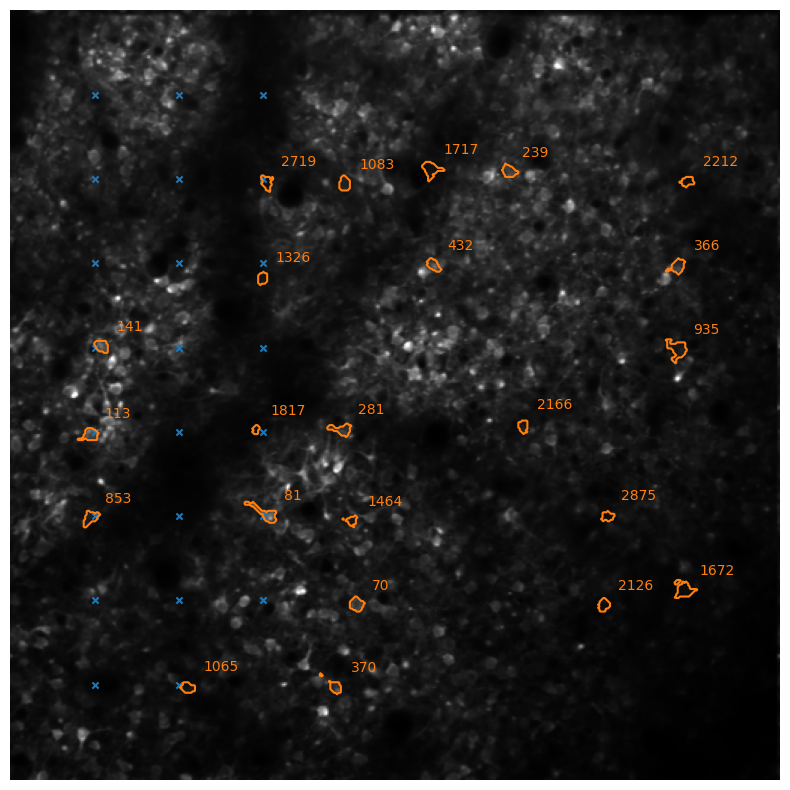

In [132]:
original_indices_sorted=np.sort(original_indices)
original_indices_all_days = original_indices_sorted[indices_all_days]
print(original_indices_all_days)
nearest_cells_sorted=np.sort(nearest_cells)
nearest_cells_all_days = nearest_cells_sorted[indices_all_days]
print(nearest_cells_all_days)
# make the same plot as above but with numbers labeled next to the roi
plt.figure(figsize=(10, 10))
# clip based on 99.99 percentile
img = ops_first['meanImg'].copy()
img[img > np.percentile(img, 99.99)] = np.percentile(img, 99.99)
plt.imshow(img, cmap='gray')

for i, cell in enumerate(nearest_cells_all_days):
    roi = np.zeros_like(ops_first['meanImg'])
    roi[stat_first_iscell[cell]['ypix'], stat_first_iscell[cell]['xpix']] = 1
    plt.contour(roi, levels=[0.5], colors='C1')
    plt.text(stat_first_iscell[cell]['med'][1]+10, stat_first_iscell[cell]['med'][0]-10, f'{original_indices_all_days[i]}', color='C1')
    #plt.scatter(grid_crosses[i][0], grid_crosses[i][1], s=20, color='C0', marker='x')

plt.axis('off')


### As above, but for cellreg

In [ ]:
CT_values= []
accuracy_values= []

for i in range (2, t2p_match_mat.shape[1] + 1):
    all_s2p_idxs_cellreg_copy = all_s2p_idxs_cellreg.copy()
    table_copy=table.copy()
    
    filtered_all_s2p_idxs_cellreg = [row[:i] if row is not None else None for row in all_s2p_idxs_cellreg_copy]
    filtered_table_copy = [row[:i] if row is not None else None for row in table_copy]

    for i in range(len(filtered_all_s2p_idxs_cellreg)):
        if filtered_all_s2p_idxs_cellreg[i] is not None: 
            if any(x is None for x in filtered_all_s2p_idxs_cellreg[i]):
                    filtered_all_s2p_idxs_cellreg[i] = None

    for i in range(len(filtered_table_copy)):
        if filtered_table_copy[i] is not None:
                if any(x is None for x in filtered_table_copy[i]):
                    filtered_table_copy[i] = None

    count = sum(1 for row in filtered_table_copy if row is not None)
    print(f'GT {count}')
    count = sum(1 for row in filtered_all_s2p_idxs_cellreg if row is not None)
    print(f'Track2p {count}')

    table_without_none = [x for x in filtered_table_copy if x is not None]
    all_s2p_idxs_cellreg_none = [x for x in filtered_all_s2p_idxs_cellreg if x is not None]
    print(len(table_without_none))
    print(len(all_s2p_idxs_cellreg_none))

    Ct, accuracy = compute_performance_criteria (all_s2p_idxs_cellreg_none, table_without_none)
    CT_values.append(round(Ct,2))
    accuracy_values.append(round(accuracy,2))

    print('')

result = np.empty((2, len(CT_values) + 1), dtype=object)
result[0, 0] = "CT"
result[1, 0] = "accuracy"
result[0, 1:] = CT_values
result[1, 1:] = accuracy_values
print(result)

np.save(os.path.join(cellreg_path, 'result_CT.npy'), result)
    

GT 51
Track2p 7
51
7
Tgt : 51
Tc : 7
Tous les éléments de la ligne [67, 38] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [81, 187] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [113, 67] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [141, 140] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [179, 521] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [239, 154] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [267, 313] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [281, 953] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [366, 118] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [370, 786] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments

In [314]:
table_cpy=table.copy()
for i in range(len(table_cpy)):
        if table_cpy[i] is not None: 
            if any(x is None for x in table_cpy[i]):
                    table_cpy[i] = None
table_all_days = [x for x in table_cpy if x is not None]
indices_all_days = [i for i, x in enumerate(table_cpy) if x is not None]
print(len(table_all_days))

all_s2p_idxs_cellreg_copy=all_s2p_idxs_cellreg.copy()
all_s2p_idxs_cellreg_gt = all_s2p_idxs_cellreg_copy[indices_all_days]
print(len(all_s2p_idxs_cellreg_gt))

CT_values= []
accuracy_values= []

for i in range (2, t2p_match_mat.shape[1] + 1):
        all_s2p_idxs_i = [row[:i] if row is not None else None for row in all_s2p_idxs_cellreg_gt]
        table_i= [row[:i] if row is not None else None for row in table_all_days]
        Ct, accuracy= compute_performance_criteria(all_s2p_idxs_i, table_i)
        CT_values.append(round(Ct,2))
        accuracy_values.append(round(Ct,2))

result = np.empty((2, len(CT_values) + 1), dtype=object)
result[0, 0] = "CT"
result[1, 0] = "accuracy"
result[0, 1:] = CT_values
result[1, 1:] = accuracy_values
print(result)

np.save(os.path.join(cellreg_path, 'result_CT_GT.npy'), result)

23
23
Tgt : 23
Tc : 23
Tous les éléments de la ligne [81, 187] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [113, 67] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [141, 140] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [239, 154] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [281, 953] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [366, 118] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [370, 786] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [432, 538] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [853, 1058] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la ligne [935, 547] ne sont pas retrouvés dans all_s2p_idxs_without_none.
Tous les éléments de la lign